### Collaborative Recommender 

This recommender uses previous user ratings to predict how the user would feel about a movie they have not seen yet. The final product is a list of unwatched movies returned, sorted by the user's estimated rating of the movie.

In [46]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import (GridSearchCV, KFold, cross_validate,
                                      train_test_split)
from surprise.model_selection.validation import cross_validate
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

print('All libraries loaded successfully!')

All libraries loaded successfully!


In [4]:
ratings = pd.read_csv('train.csv')

In [5]:
ratings.shape

(10000038, 4)

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [8]:
movies = pd.read_csv('movies.csv')

In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
movies.shape

(62423, 3)

In [11]:
rated_movs = ratings.groupby('movieId').sum()
rated_movs.shape

(48213, 3)

In [12]:
users = ratings.groupby('userId').sum()
users.shape

(162541, 3)

We're seeing 10 Million ratings on 48 213 movies made by 162 541 users

In [16]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = ratings['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / ratings.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} movie-ratings'.format(ratings.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see from the above that over 26% of the movies are rated 4. Ratings 0 to 2,5 together is less than 16%

In [17]:
tags = pd.read_csv('genome_tags.csv')
tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [18]:
genome_scores = pd.read_csv('genome_scores.csv')
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [19]:
genome_scores.shape

(15584448, 3)

In [20]:
links = pd.read_csv('links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [21]:
links.shape

(62423, 3)

In [22]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 162541 | Number of movies = 48213


While using Surprise, one can use a bunch of built-in datasets (e.g.movielens) parsed by Dataset module. However, it is usually required to build a customized recommender system. In a case as such, it is necessary to upload your own rating dataset either from a file (e.g. csv) or from a pandas' dataframe. In both cases, you need to define a Reader object to parse the file or the dataframe by Surprise. See the reference [here](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset)

In [23]:
reader = Reader(rating_scale=(1, 5))

Now, we upload the dataframe with ratings per user by movie with Dataset.load_from_df and specify reader as the argument

In [24]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

### Singular Value Decomposition (SVD)
SVD decomposes any matrix into singular vectors and singular values. If the reader has previous experience with machine learning, particularly with dimensionality reduction, they would find traditional use of SVD in Principal Component Analysis (PCA). Simply put, SVD is equivalent to PCA after mean centering, i.e. shifting all data points so that their mean is on the origin

- We will use the SVD Algorithm 
- For training and tuning: GridSearchCV, RMSE(stochastic gradient descent)

In [30]:
from surprise import accuracy
# define a cross-validation iterator

start = time.time()

kf = KFold(n_splits=5)

svd = SVD(verbose=True)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    svd.fit(trainset)
    alt_pred = svd.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(alt_pred, verbose=True)
    
print("Runtime %0.2f" % (time.time() - start))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.8339
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.8347
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Proc

In [31]:
rmses = [0.8339,0.8347,0.8343,0.8345,0.8330]
rmse_avg = round(sum(rmses) / len(rmses),5)
print('The mean RMSE of the full rating set is: {}'.format(rmse_avg))

The mean RMSE of the full rating set is: 0.83408


In [32]:
algo.predict(345,3954)

Prediction(uid=345, iid=3954, r_ui=None, est=2.9362459132868484, details={'was_impossible': False})

In [33]:
ratings[ratings['userId'] == 345]

,userId,movieId,rating,timestamp
216054,345,3994,4.0,993599074
270581,345,4719,3.0,998526932
333635,345,3007,5.0,984634410
403714,345,3016,3.0,985056833
484246,345,1717,3.0,984709140
...,...,...,...,...
9770229,345,1257,4.0,1022690433
9822387,345,4623,3.0,994452087
9857127,345,7327,5.0,1088037668
9868340,345,593,5.0,985223110


### Analysis so far....

Our SVD algorithm has a RMSE of 0.83408, which is fine. Ratings tend to be centeralized, leaning toward mean ratings around 3-4 for every movie predicted. Lets see if this has to do with the distribution of ratings in the raw data and what we would get if we scaled it down to have a more even number of ratings in each bin.

<AxesSubplot:xlabel='rating'>

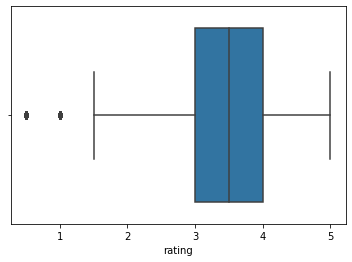

In [34]:
sns.boxplot(ratings['rating'])

Our results tend to fall within the boxplot's allotment for 'mean' ratings, meaning it might not be perfectly correct for specified users. We'll try training with a more even set.

In [35]:
ratings['rating'].value_counts()

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5     880516
2.0     656821
2.5     505578
1.0     311213
1.5     159731
0.5     157571
Name: rating, dtype: int64

In [36]:
alt_ratings = 4

In [37]:
sub_sample = (3.0,ratings)

In [38]:
alt_ratings = pd.DataFrame()
my_ratings = [4.0,3.0,5.0,3.5,4.5,2.0]
for rating in my_ratings:
    temp_df = ratings[ratings['rating'] == rating]
    temp_df = temp_df.sample(n=100000)
    alt_ratings = pd.concat([alt_ratings,temp_df],axis=0)

In [39]:
alt_ratings.shape

(600000, 4)

In [40]:
alt_ratings = alt_ratings.drop('timestamp',axis=1)
ratings = ratings.drop('timestamp',axis=1)

In [41]:
ratings_left = [2.5,1.0,1.5,0.5]
for rating in ratings_left:
    temp_df = ratings[ratings['rating'] == rating]
    alt_ratings = pd.concat([alt_ratings,temp_df],axis=0)

In [42]:
alt_ratings['rating'].value_counts()

2.5    505578
1.0    311213
1.5    159731
0.5    157571
5.0    100000
4.5    100000
4.0    100000
3.5    100000
3.0    100000
2.0    100000
Name: rating, dtype: int64

Now we have 100,000 ratings each of 2 to 5, and all the previous ratings of 0.5 to 2.5 stars. We are using a subsample, lets check how many users or movies were lost. 

#### Now we look at the adjusted distribution with ratings randomly subsampled

Text(0.5, 1.0, 'Rating Distribution (adjusted)')

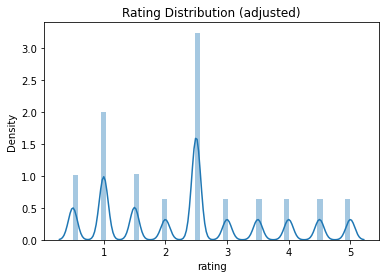

In [44]:
sns.distplot(alt_ratings['rating'])
plt.title('Rating Distribution (adjusted)')

In [45]:
# define a cross-validation iterator

start = time.time()

kf = KFold(n_splits=5)

svd = SVD(verbose=True)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    svd.fit(trainset)
    alt_pred = svd.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(alt_pred, verbose=True)
    
print("Runtime %0.2f" % (time.time() - start))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.8345
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.8351
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Proc

In [47]:
rmses = [0.8345,0.8351,0.8332,0.8338,0.8340]
rmse_avg = round(sum(rmses) / len(rmses),5)
print('The mean RMSE of the adjusted rating set is: {}'.format(rmse_avg))

The mean RMSE of the adjusted rating set is: 0.83412


In [48]:
ratings['userId'].value_counts().mean()

61.52317261490947

In [49]:
alt_ratings.head()

,userId,movieId,rating
1295610,54507,7438,4.0
7331744,12825,316,4.0
6595819,134628,1961,4.0
2048711,114411,1094,4.0
2377748,147342,1089,4.0


Now we will create a  function checks the predicted rating against ratings made by the user and takes in an int UserId (Id)
an int limit (the number of movies returned)dataframe columns necessary (movieId, userId)a dataframe of ratings (df)
an algorithm (algo)

In [50]:
def check_system(Id,movieId,limit,df=ratings,userId='userId',algo=algo):
     # Isolates necessary columns from the dataframe
    df = df[[movieId,userId,'rating']]
    
    # Takes a subsample of the user's ratings
    user_df = df[df['userId'] == Id]
    if user_df.shape[0] >= df[userId].value_counts().mean():
        user_df = user_df.sample(frac=.10)
    else:
        user_df = user_df.sample(frac=.50)

    # Builds the dataframe to be returned     
    user_df['est'] = user_df['movieId'].apply(lambda x: round(algo.predict(Id,x).est,2))
    user_df['error'] = user_df['est']-user_df['rating']
    user_df['avg_error'] = user_df['error'].mean()
    
    # Returns a dataframe dependent on what the limit is set to
    if limit == None:
        user_df = pd.merge(user_df,movies,on=movieId)
        return user_df[[userId,movieId,'title','rating','est','error','avg_error']]
    else:
        if limit >= user_df.shape[0]:
            user_df = pd.merge(user_df,movies,on=movieId)
            return user_df[[userId,movieId,'title','rating','est','error','avg_error']]
        else:
            user_df = user_df.head(limit)
            user_df = pd.merge(user_df,movies,on=movieId)
            return user_df[[userId,movieId,'title','rating','est','error','avg_error']]

In [51]:
alt_ratings['userId'].value_counts().describe()

count    144355.000000
mean         12.012698
std          30.744285
min           1.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        3525.000000
Name: userId, dtype: float64

In [52]:
ratings['userId'].value_counts().describe()

count    162541.000000
mean         61.523173
std         107.410889
min           1.000000
25%          14.000000
50%          28.000000
75%          65.000000
max       12952.000000
Name: userId, dtype: float64

Lets check how predictions turn on for users who have:
        
1. Rated a lot ofmovies (large data to pull from)
2. Rated an average number of movies
3. Rated few movies

#### Let us first check for the user who rated the most amount of movies (12,952 ratings)

In [54]:
find_user = ratings.copy()
find_user['count'] = 1
find_user = find_user.groupby('userId').sum()
find_user[find_user['count'] == 12952].head(1)

,movieId,rating,count
userId,,,
72315,1354159835,40052.5,12952


#### User 72315 has the most ratings - 12,952!! Let's get 10 ratings from this user

In [55]:
check_system(72315, 'movieId', 10)

,userId,movieId,title,rating,est,error,avg_error
0,72315,150776,Tag (2015),3.0,3.05,0.05,0.021575
1,72315,6161,Painted Fire (Chihwaseon) (2002),4.0,3.24,-0.76,0.021575
2,72315,26227,House of Dark Shadows (1970),2.0,2.88,0.88,0.021575
3,72315,96212,"One Percent, The (2006)",3.0,2.92,-0.08,0.021575
4,72315,6835,Alien Contamination (1980),2.5,2.58,0.08,0.021575
5,72315,32582,"Wild Parrots of Telegraph Hill, The (2003)",4.5,3.58,-0.92,0.021575
6,72315,134174,Follow Me: The Yoni Netanyahu Story (2012),3.0,2.89,-0.11,0.021575
7,72315,91707,In the Land of Blood and Honey (2011),2.5,3.37,0.87,0.021575
8,72315,92380,Jenny (1936),2.5,3.03,0.53,0.021575
9,72315,58975,"Ruins, The (2008)",2.5,2.57,0.07,0.021575


#### Let us check for the user who rated an average amount of movies (61 ratings)

In [57]:
find_user = ratings.copy()
find_user['count'] = 1
find_user = find_user.groupby('userId').sum()
find_user[find_user['count'] == 61].head(1)

,movieId,rating,count
userId,,,
333,145588,235.0,61


#### User 333 has average amount of ratings - 61 - Let's get 10 ratings from this user

In [58]:
check_system(333, 'movieId', 10)

,userId,movieId,title,rating,est,error,avg_error
0,333,329,Star Trek: Generations (1994),1.0,3.21,2.21,0.256333
1,333,2616,Dick Tracy (1990),5.0,3.01,-1.99,0.256333
2,333,2881,Double Jeopardy (1999),5.0,4.26,-0.74,0.256333
3,333,27,Now and Then (1995),4.0,3.82,-0.18,0.256333
4,333,3752,"Me, Myself & Irene (2000)",1.0,3.11,2.11,0.256333
5,333,3147,"Green Mile, The (1999)",5.0,4.94,-0.06,0.256333
6,333,3824,Autumn in New York (2000),3.0,2.94,-0.06,0.256333
7,333,648,Mission: Impossible (1996),3.0,3.76,0.76,0.256333
8,333,4994,"Majestic, The (2001)",1.0,4.11,3.11,0.256333
9,333,3831,Saving Grace (2000),4.0,4.38,0.38,0.256333


#### Let us check for the user who rated a below average amount of movies (14 ratings)

In [61]:
find_user = ratings.copy()
find_user['count'] = 1
find_user = find_user.groupby('userId').sum()
find_user[find_user['count'] == 14].head(1)

,movieId,rating,count
userId,,,
17,1198838,52.0,14


#### User 17 has below average amount of ratings - 174 - Let's get 10 ratings from this user

In [62]:
check_system(17, 'movieId', 10)

,userId,movieId,title,rating,est,error,avg_error
0,17,68954,Up (2009),3.5,3.90,0.40,-0.384286
1,17,36086,Dilwale Dulhania Le Jayenge (1995),4.0,3.75,-0.25,-0.384286
2,17,102125,Iron Man 3 (2013),5.0,4.02,-0.98,-0.384286
3,17,62999,Madagascar: Escape 2 Africa (2008),5.0,3.87,-1.13,-0.384286
4,17,72998,Avatar (2009),4.5,4.12,-0.38,-0.384286
5,17,79091,Despicable Me (2010),5.0,3.49,-1.51,-0.384286
6,17,6377,Finding Nemo (2003),2.5,3.66,1.16,-0.384286


In [63]:
movies_df = pd.read_csv('movies.csv')
movies_df = movies_df[['movieId','title']]
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


### Predicting ratings 

In [64]:
trainset = data.build_full_trainset()

In [65]:
model = SVD(verbose=True)
model = model.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [67]:
test = pd.read_csv("test.csv")
test

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318
...,...,...
5000014,162541,4079
5000015,162541,4467
5000016,162541,4980
5000017,162541,5689


#### Creating a submission file 

In [69]:
# this will take a while, be patient runnint it :)
def predict_rating(row):
    u = row["userId"]
    i = row["movieId"]
    return model.estimate(u, i) # name of the model here

test = test.assign(rating=test.apply(predict_rating, axis=1))

In [70]:
test = test.assign(Id=test.userId.astype(str)+"_"+test.movieId.astype(str))
submission = test[["Id", "rating"]]
submission.to_csv("submission_svd.csv", index=None)

In [71]:
def predict_ratings(Id, movieId, n, df=ratings, userId='userId', algo=algo):
    # Select some random movies from our set
    df = df[[movieId,userId,'rating']]
    movie_choices = df[movieId].unique()
    movies = np.random.choice(movie_choices,n)
    
    # Build the dataframe that we'll return
    predicted_df = pd.DataFrame()
    predicted_df['movieId'] = movies
    predicted_df['userId'] = Id
    
    predicted_df['est'] = predicted_df['movieId'].apply(lambda x: round(algo.predict(Id,x).est,2))
    
    # Grabbing the titles
    predicted_df = pd.merge(predicted_df,movies_df,on='movieId')
    
    
    return predicted_df[[userId,movieId,'title','est']]

In [72]:
predict_ratings(551,'movieId',10)

,userId,movieId,title,est
0,551,90664,"Gold of Naples, The (L'oro di Napoli) (1954)",3.47
1,551,115875,Toy Story Toons: Hawaiian Vacation (2011),3.58
2,551,103374,May I Kill U? (2012),3.59
3,551,300,Quiz Show (1994),3.73
4,551,8827,"Bill Cosby, Himself (1983)",3.93
5,551,153174,The Garden (1995),3.58
6,551,40467,"Gorgon, The (1964)",3.30
7,551,198599,Time Indefinite (1993),3.39
8,551,163913,Devil's Bride (2016),3.16
9,551,101299,"Finger, The (Dedo, El) (2011)",3.54


#### We will create a function that returns n movies, sorted by predicted user rating, from a random sample of movies

In [74]:
def predicted_top_n(Id, movieId, n, samples, df=ratings, userId='userId', algo=algo):
    
    df = df[[movieId,userId,'rating']]

    movie_choices = df[movieId].unique()
    
    # Take out movies the user has already watched
    temp_df = ratings[ratings[userId] == Id]
    watched_movs = temp_df[movieId].unique()
    unwatched = np.setdiff1d(movie_choices,watched_movs)
    
    # Select random movies according to 'samples'
    if samples == None:
        movies = unwatched
        samples = movies.shape[0]
    elif samples <= unwatched.shape[0]:
         movies = np.random.choice(unwatched,samples)
    else:
        print("The sample size exceeds the available movies. Reset to {} movies".format(unwatched.shape[0]))
        movies = unwatched
        samples = movies.shape[0]
        
    # Build the dataframe that we'll return
    predicted_df = pd.DataFrame()
    predicted_df[movieId] = movies
    predicted_df[userId] = Id
    predicted_df['est'] = predicted_df[movieId].apply(lambda x: round(algo.predict(Id,x).est,2))
    predicted_df = predicted_df.sort_values(by='est', ascending=False)
    
    if n >= samples:
        predicted_df = pd.merge(predicted_df,movies_df,on=movieId)
        return predicted_df[[userId,'title','est']]
    else:
        predicted_df = predicted_df.head(n)
        predicted_df = pd.merge(predicted_df,movies_df,on=movieId)
        return predicted_df[[userId,'title','est']] 
    

### Recommending unwatched movies

We wrote a function that does the following:

1. Creates a filtered list of movies that the user in question hasn't rated (ie hasn't watched)
2. The user is allowed to subsample a smaller set of movies if they want
3. If the user does not do above, all movies in the set are considered
4. A filtered dataframe is returned of unwatched movies and the user's estimated rating of the movie, sorted by the estimated rating
5. The user chooses how many movies they want.

### User with the most ratings (User 72315, 12952 ratings)

In [75]:
predicted_top_n(72315, 'movieId', 10, None)

,userId,title,est
0,72315,Seven Samurai (Shichinin no samurai) (1954),4.31
1,72315,Citizen Kane (1941),4.20
2,72315,Band of Brothers (2001),4.19
3,72315,M (1931),4.16
4,72315,Some Folks Call It a Sling Blade (1993),4.15
5,72315,All About Eve (1950),4.14
6,72315,City Lights (1931),4.14
7,72315,Duck Amuck (1953),4.14
8,72315,Planet Earth (2006),4.13
9,72315,Lawrence of Arabia (1962),4.12


User with average amount of ratings (User 333, 61 ratings)

In [77]:
predicted_top_n(333, 'movieId', 10, None)

,userId,title,est
0,333,Cosmos,5.00
1,333,Dead Poets Society (1989),5.00
2,333,Life Is Beautiful (La Vita è bella) (1997),5.00
3,333,Planet Earth (2006),5.00
4,333,Planet Earth II (2016),4.97
5,333,"Beautiful Mind, A (2001)",4.96
6,333,Pride (2014),4.96
7,333,George Carlin: Back in Town (1996),4.94
8,333,We Were Here (2011),4.94
9,333,"American President, The (1995)",4.93


### User with the below-average number of ratings (User 17, 14 ratings)

In [78]:
predicted_top_n(17, 'movieId', 10, None)

,userId,title,est
0,17,Cosmos,4.72
1,17,Rabbit of Seville (1950),4.52
2,17,Magnetic Rose (1995),4.52
3,17,Gaslight (1944),4.49
4,17,"Night, The (Notte, La) (1960)",4.48
5,17,Before the Rain (Pred dozhdot) (1994),4.46
6,17,Bitter Lake (2015),4.44
7,17,"Power of Nightmares, The: The Rise of the Poli...",4.42
8,17,"Help, The (2011)",4.42
9,17,Human (2015),4.42


### References 

- Hug, N.(2015). Getting started with Surprise. Retrieved from https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset


- Chen, D.(2020). Recommender System — singular value decomposition (SVD) & truncated SVD. Retrieved from https://towardsdatascience.com/recommender-system-singular-value-decomposition-svd-truncated-svd-97096338f361


- Sharma, P.(2018). Comprehensive Guide to build a Recommendation Engine from scratch (in Python). Retrieved from https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/


- Deisenroth, M.P., Faisal, A.A., Ong C.S.(2021). Mathematics for Machine Learning, pg.98-105 and pg.317-343